# Detecção de Fraudes em Cartões de Crédito

As fraudes financeiras representam um problema bilionário e uma das maiores preocupações de bancos e *fintechs*. Apenas no Brasil, os golpes ultrapassaram a cifra de **R$ 1,8 bilhão** em prejuízos no último ano, vitimando cerca de 12,1 milhões de pessoas.

Nesse cenário, a fraude com cartões de crédito é especialmente crítica. Sua não detecção resulta em perdas significativas tanto para o consumidor quanto para a instituição financeira, abalando a confiança e a segurança do sistema.

<p align="center">
  <img src="img/cartao_credito.png" width="60%">
</p>
<p align="center">
  <i><small>Fonte: Google Gemini (2025)</small></i>
</p>

No entanto, o desafio vai além de simplesmente barrar transações ilegítimas. Quem nunca passou pela frustração de ter uma compra legítima negada por suspeita de fraude? Esse é o problema dos **falsos positivos**: o bloqueio preventivo de transações válidas, que gera estresse e constrangimento para o cliente.

É nesse complexo balanço entre segurança máxima e uma boa experiência do usuário que a Inteligência Artificial se torna uma ferramenta indispensável. O investimento na área de detecção de fraudes por meio de *Data Science* cresce a cada ano, representando uma oportunidade imensa para o setor.

Com o gigantesco volume de dados transacionais disponíveis, um modelo de *machine learning* com uma performance marginalmente superior à dos modelos anteriores já pode representar uma **economia de milhões de reais**. O desafio deste projeto é exatamente este: aprimorar o uso de algoritmos para desenvolver um sistema de detecção de fraudes que seja, ao mesmo tempo, preciso e eficiente.

## Importando os Dados

Os dados que utilizaremos neste projeto foram originalmente coletados de transações com cartões de crédito na Europa. O *dataset*, disponibilizado por empresas do setor, abrange um período de dois dias e contém quase 290 mil transações, das quais 492 foram classificadas como fraudulentas.

Um ponto de atenção imediato é o **severo desbalanceamento** dos dados:

> As fraudes representam apenas **0,17%** do total de transações.

Essa característica é um desafio central para a construção de um modelo preditivo eficaz e guiará muitas das nossas decisões nas próximas etapas.

### Privacidade e Análise de Componentes Principais (PCA)

Por questões de privacidade e segurança, as características originais do *dataset* (`features`) não foram divulgadas. Em seu lugar, encontramos um conjunto de colunas numéricas e anônimas, nomeadas de $V1, V2, V3, \dots, V28$.

<p align="center">
<img src="img/import_data.png" width="50%"></p>
<p align="center">
  <i><small>Fonte: Google Gemini (2025)</small></i>
</p>

Conforme informado na [página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), essas *features* anônimas são, na verdade, o resultado da aplicação de uma técnica de redução de dimensionalidade chamada **Análise de Componentes Principais** (*Principal Component Analysis* - PCA).

O PCA transforma as variáveis originais em um novo conjunto de variáveis (os chamados **componentes principais**), que não possuem uma interpretação de negócio direta, mas que retêm o máximo possível da informação e da variância dos dados. No contexto deste projeto, as colunas $V1, V2, \dots, V28$ são precisamente esses componentes.

In [1]:
#@title
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# instalar a biblioteca scikit-plot
#!pip install -q scikit-plot

In [2]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import scikitplot as pltt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

Para facilitar a aquisição dos dados, criei um *link* com acesso direto ao `csv`. Com isso, basta importar o conjunto de dados usando o método `pd.read_csv()`. Esta linha de código está comentada, porém, caso queiram utilizar o arquivo é só descomentar.

In [6]:
# importar os dados para um dataframe
#file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"
file_path = "https://onsenacrn-my.sharepoint.com/:x:/g/personal/i4072_rn_senac_br/EVjwEjdmA-dNoacIWJRu_jkBti6L3adUzub6QNrmrnVpBA?e=DrEx3S"
# Caminho absoluto (recomendado se houver dúvidas)
#file_path = r"c:\Users\USER\Documents\SENAC\Transacoes_Financeiras\creditcard.csv"
df = pd.read_csv(file_path)

HTTPError: HTTP Error 401: Unauthorized

Com os dados importados para dentro de uma estrutura *Dataframe* - e não havendo a necessidade de mais nenhum ajuste ou configuração nesta etapa, pode-se iniciar uma análise exploratória dos dados a fim de preparar um modelo de *Machine Learning*.

## Análise Exploratória

Apenas olhando as cinco primeiras entradas é possível tirar algumas conclusões:

* As 5 primeiras entradas permitem entender como a transformação PCA deixou as *features* descaracterizadas (anônimas) e em valores numéricos. Para saber mais sobre PCA, [clique neste *link*](http://www2.ic.uff.br/~aconci/PCA-ACP.pdf).

* As colunas `Time` e `Amount` foram preservadas, mantendo seu valor original.

* A variável alvo está representada na coluna `Class`, onde:
    * **0:** Transação normal; e
    * **1:** Transação fraudulenta;

In [21]:
# ver as primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Verificando abaixo o resumo estatístico, por meio do método `describe()`, podemos confirmar que as variáveis relativas aos componentes principais (transformação PCA) não têm nenhuma discrepância aparente, bem como a coluna `Time`.

Em relação à variável `Amount`, nota-se que o valor médio de transações (considerando ambas as classes) é 88.34, mediana igual a 22.00 e desvio padrão de 250.12. Atingindo o valor máximo de 25691.16, a maioria das transações financeiras é composta em sua maioria por quantias menores - como esperado.



In [22]:
# ver o resumo estatístico
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Quanto à qualidade do *dataset*, este não apresentou nenhum valor ausente ou que demandasse uma etapa de limpeza. Na função abaixo, perceba que o maior valor por coluna para valores nulos é zero, o que confirma que não há valores ausentes.

In [23]:
# ver se há valores ausentes
df.isnull().sum().max()

np.int64(0)

Como é [informado na descrição dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), as entradas relativas à transações fraudulentas correspondem a 0,17% do total.

O gráfico de barras mostra como essa discrepância se torna nítida e visível. Na prática, isso interfere no desempenho do modelo, e será necessário fazer um balanceamento dos dados antes de alimentar o modelo final de classificação.

Class
0    284315
1       492
Name: count, dtype: int64

Fraudes representam 0.1727% do dataset.



[]

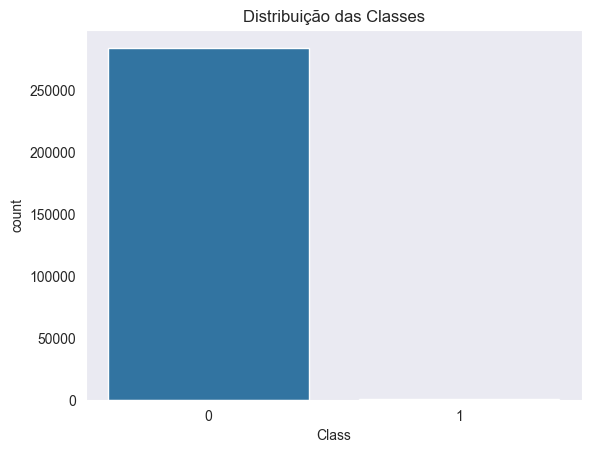

In [24]:
# ver o balanceamento das classes
print(df.Class.value_counts())
print("\nFraudes representam {:.4f}% do dataset.\n".format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

# plotar gráfico de barras para as Classes
fig, ax = plt.subplots()
sns.countplot(x='Class', data=df, ax=ax) # Corrected line
ax.set_title('Distribuição das Classes')
plt.plot()

Plotou-se também dois gráficos a fim de comparar as distribuições das 2 classes ao longo da dimensão tempo (`Time`). No entanto, não foi identificada nenhum informação a partir das distribuições de frequência abaixo.

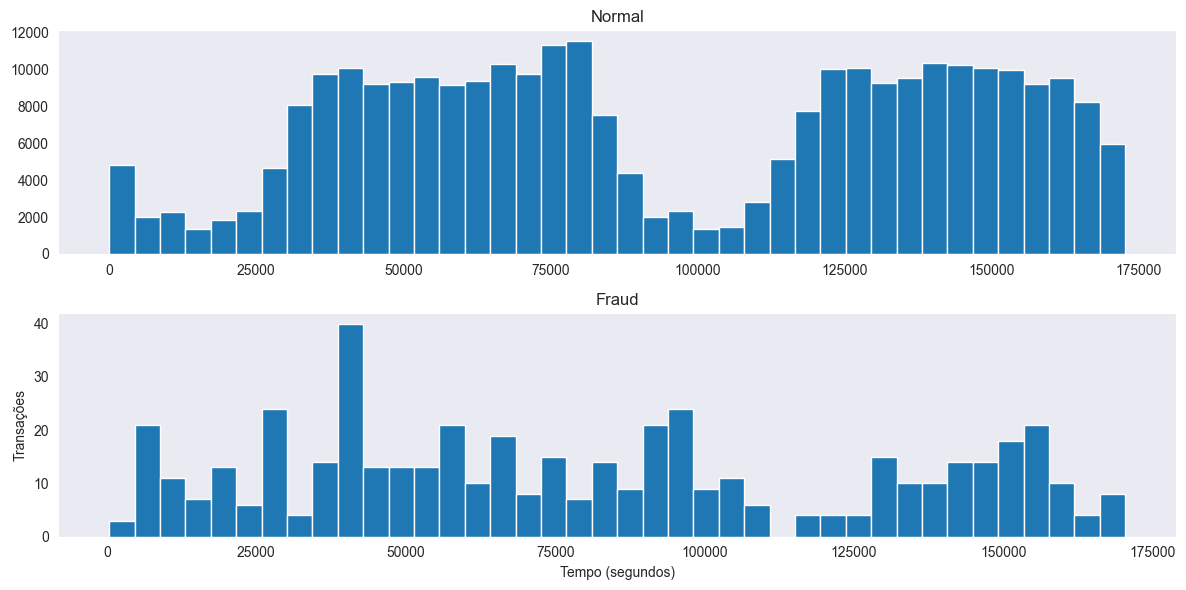

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins = 40

ax[0].hist(df.Time[df.Class == 0], bins=num_bins)
ax[0].set_title('Normal')

ax[1].hist(df.Time[df.Class == 1], bins=num_bins)
ax[1].set_title('Fraud')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.tight_layout()

Seguindo a análise exploratória, plotou-se os *boxplots* para ver se há alguma diferença no padrão transações em relação à dimensão `Amount`.

De uma maneira geral, percebe-se uma distribuição diferente para as duas classes, o que provavelmente irá contribuir para o treinamento do modelo de *machine learning*.

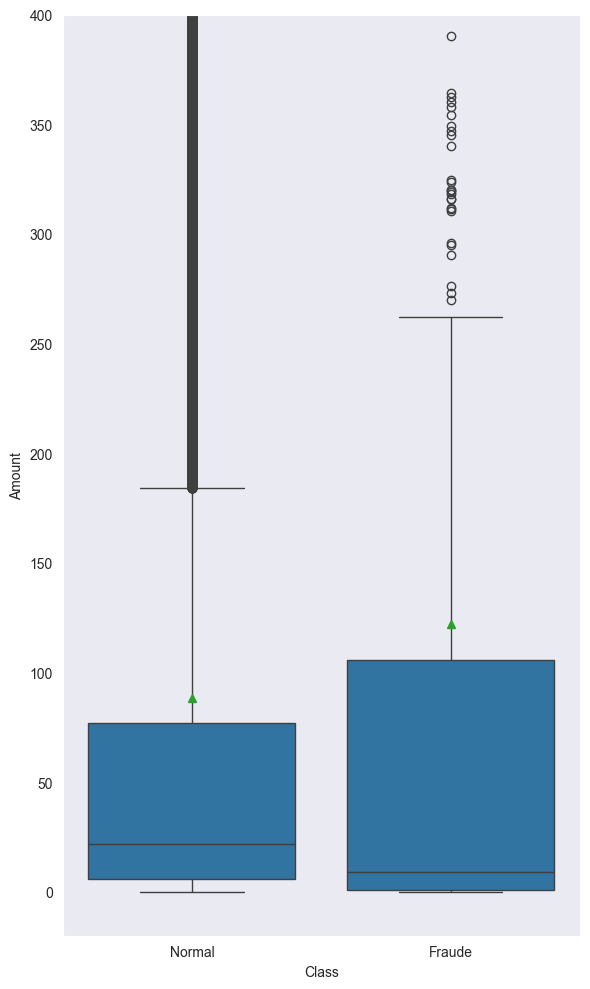

In [26]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(x=df.Class, y=df.Amount, showmeans=True, ax=ax)
plt.ylim((-20, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.tight_layout()

As informações estatísticas para `df.Class == 1` mostram que a sua média exata está em 118.13 e a mediana em 9.21.

In [27]:
df[(df.Class == 1) & (df.Amount < 2000)]['Amount'].describe()

count     491.000000
mean      118.130550
std       240.439028
min         0.000000
25%         1.000000
50%         9.210000
75%       105.350000
max      1809.680000
Name: Amount, dtype: float64

O gráfico de densidade é muito útil para compararmos as distribuições de cada variável para cada classe e ver quais as mais importantes para detecção de anomalias.

O que se procura nesse tipo de visualização são distribuições que diferem uma da outra, permitindo identificar fraudes mais facilmente. Veja como exemplo as variáveis `V3`, `V4`, `V10` e `V11`, como elas são bem distintas.

Por outro lado, variáveis como `V8`, `V13` e `V15` são muito similares, apresentando aproximadamente o mesmo comportamento.

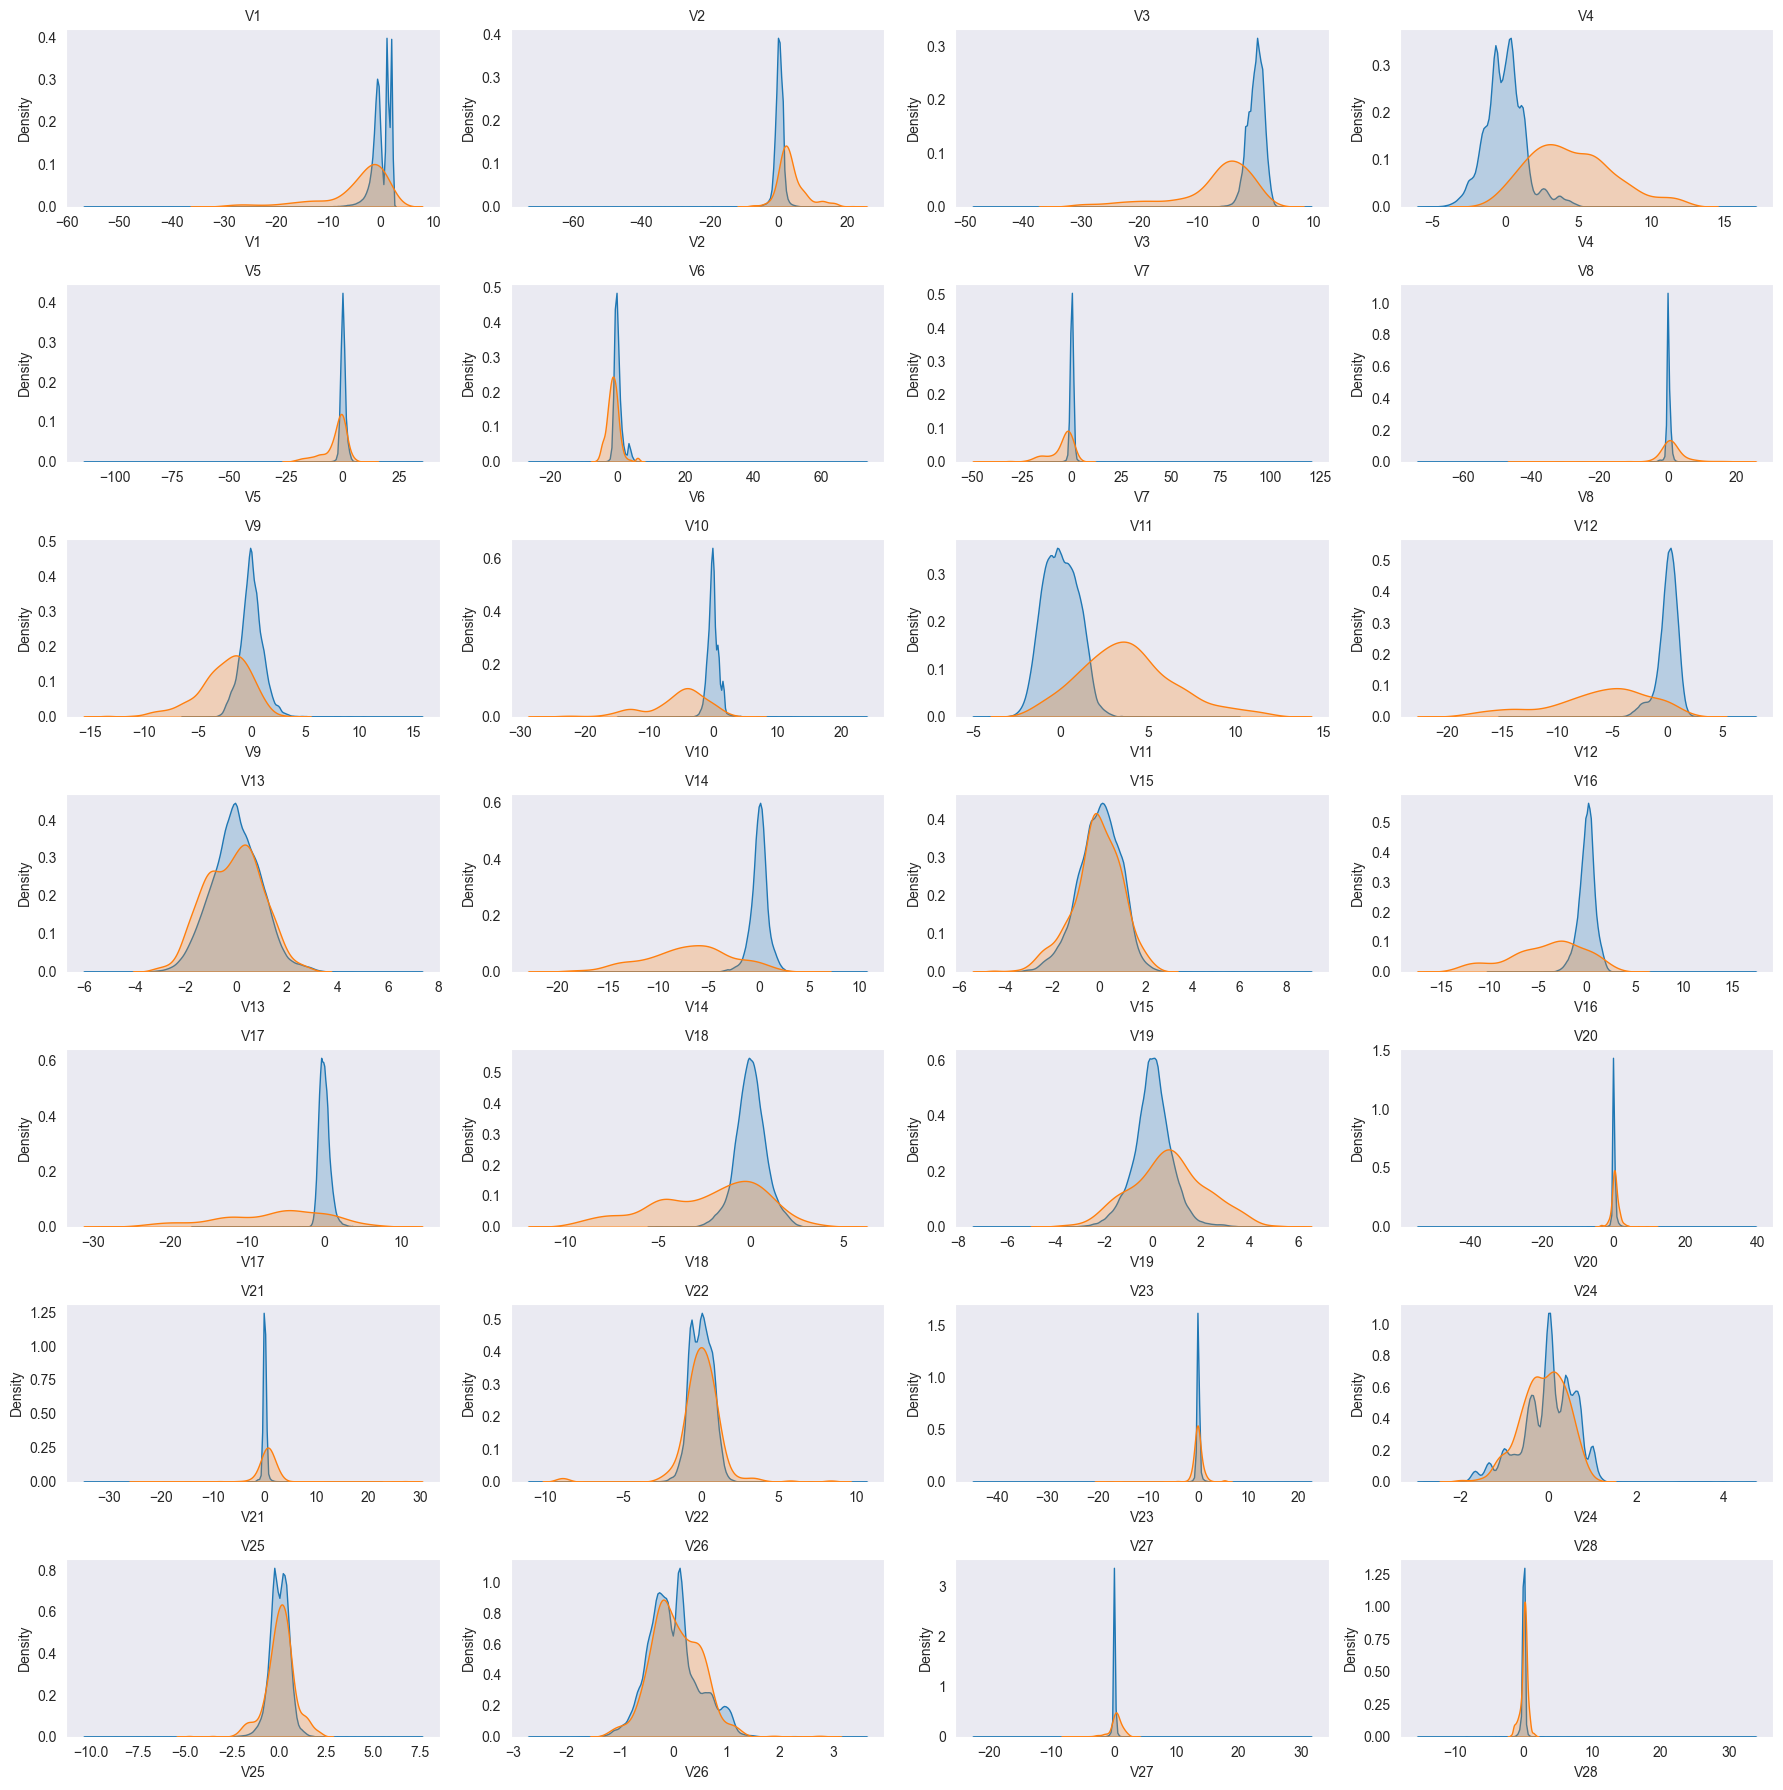

In [28]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()


Resumidamente, algumas observações principais que puderam ser extraídas dessa etapa exploratória foram:

* O *dataset* está muito desbalanceado, uma vez que as transações fraudulentas representam apenas 0,17% das entradas totais.
* Não existem valores ausentes ou nulos no *dataframe*.
* Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa que as *features* originais foram padronizadas.
* As colunas `Time` e `Amount` não estão normalizadas.

## Preparando os dados

Para que os dados possam alimentar o modelo de Regressão Logística que iremos construir, nesta etapa de preparação iremos:

* Padronizar as *features* `Time` e `Amount`, que estão em outra ordem de grandeza.
* Dividir entre dados de treino e teste
* Balancear os dados a fim de evitar uma baixa performance para a classe 1 e *overfitting*.

**Padronizar `Time` e `Amount`**

Para esta etapa, uma vez que a coluna `Amount` possui *outliers* será usada a padronização por meio da classe `StandardScaler`.

In [29]:
# padronizar as colunas Time e Amount
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# ver as primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


**Dividir entre conjuntos de treino e teste**

Antes de proceder com o balanceamento de dados, devemos splitar os dados já existentes entre treino e teste. Caso contrário, não teremos parâmetros para conferir se o balanceamento foi adequado.

Para garantir que os conjuntos de treino e teste tenham a mesma quantidade de classes proporcionalmente, passamos `stratify=True`.

In [30]:
# separar variáveis entre X e y
X = df_clean.drop('Class', axis=1)
y = df['Class']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

**Balanceamento dos dados**

Usando a biblioteca `imblearn` é possível aplicar facilmente técnicas de balanceamento de dados. No caso, a opção neste projeto foi usar *Under-sampling*, preservando a classe minoritária.

É fácil ver que não há mais aquela discrepância inicial (gráfico de barras no início deste *notebook*).

Class
0    369
1    369
Name: count, dtype: int64


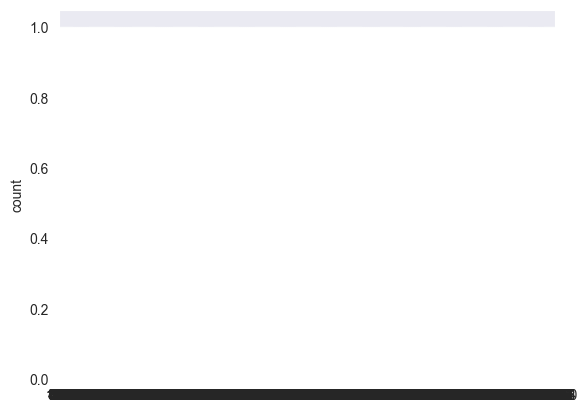

In [31]:
# usar técnica under-sampling
rus = RandomUnderSampler()
#X_rus, y_rus = rus.fit_sample(X_train, y_train)
X_rus, y_rus = rus.fit_resample(X_train, y_train) # Corrected method name

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_rus);

Com os dados balanceados, podemos ver a matriz de correlação e identificar quais variáveis estão mais fortemente relacionadas com as outras.

Observe como anteriormente, sem o balanceamento de dados, a matriz de correlação não trazia nenhuma informação relevante. Entretanto, ela traz muito mais informações após um correto balanceamento.

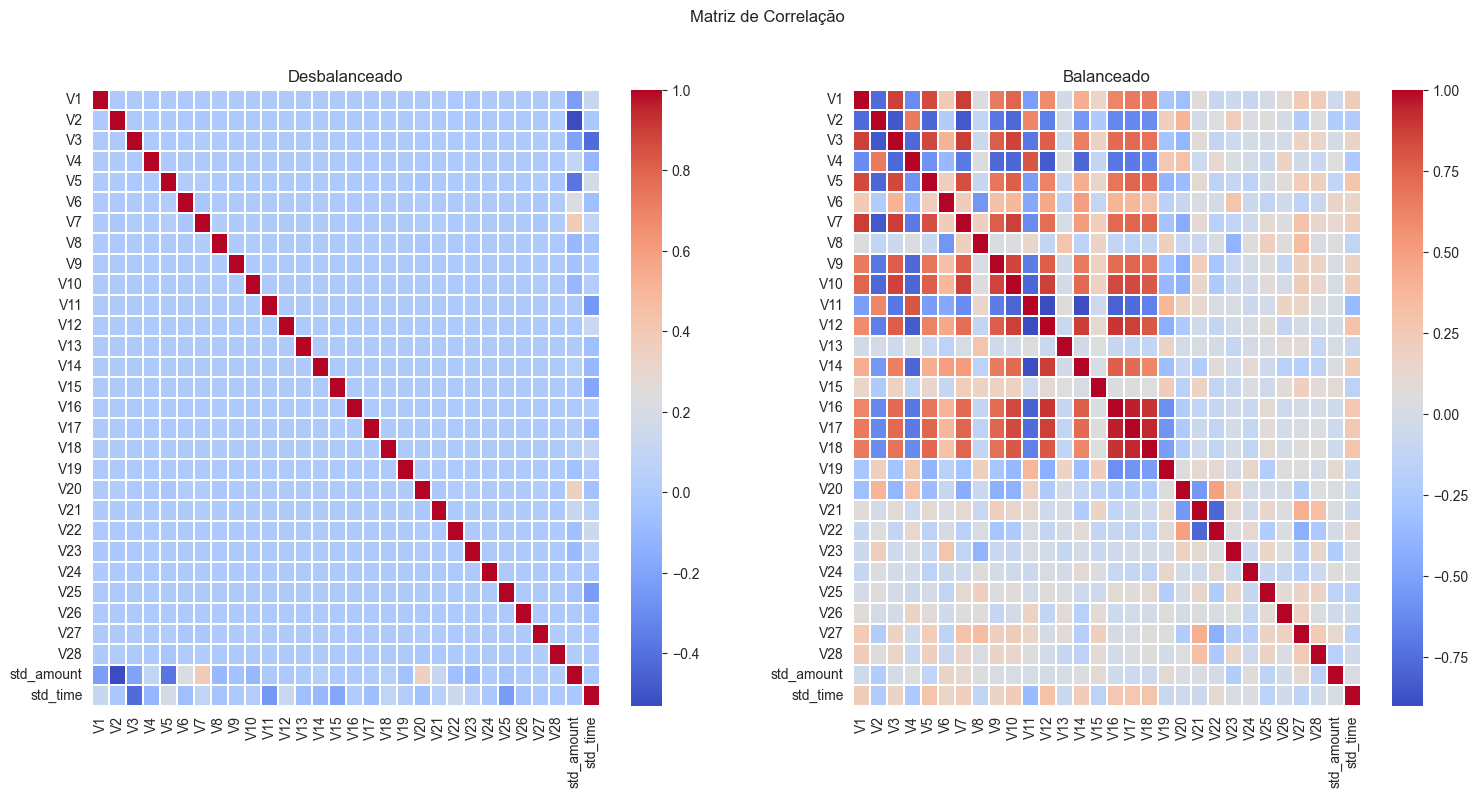

In [32]:
# plotar a matriz de correlação
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

## Modelo de Machine Learning

Com todos os dados preparados e após uma análise exploratória completa, irei construir um classificador usando a Regressão Logística.

Após instanciar o modelo, o mesmo será treinado em cima dos dados em `X_rus` e `y_rus`. Na sequência, serão realizadas as previsões sobre os dados de teste.

In [33]:
# instanciar e treinar um modelo de Regressão Logística
np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus, y_rus)

# fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Com o modelo treinado e as previsões feitas, parte-se para a avaliação do desempenho.

Neste tipo de problema, originalmente desbalanceado, a acurácia não é uma métrica adequada. Como expliquei [neste artigo](http://sigmoidal.ai/como-lidar-com-dados-desbalanceados/), você pode ter uma acurácia de 99,88% e detectar menos de 60% das fraudes.

Observe a matriz de confusão para ver a taxa de acertos para transações fraudulentes, ou pela coluna *recall* do Relatório de Classificação.

Uma outra métrica considerada interessante para se avaliar a eficácia é a [AUC ROC](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772), ou área sob a curva. No caso desse modelo de Regressão Logística, tem-se 95% de AUC.

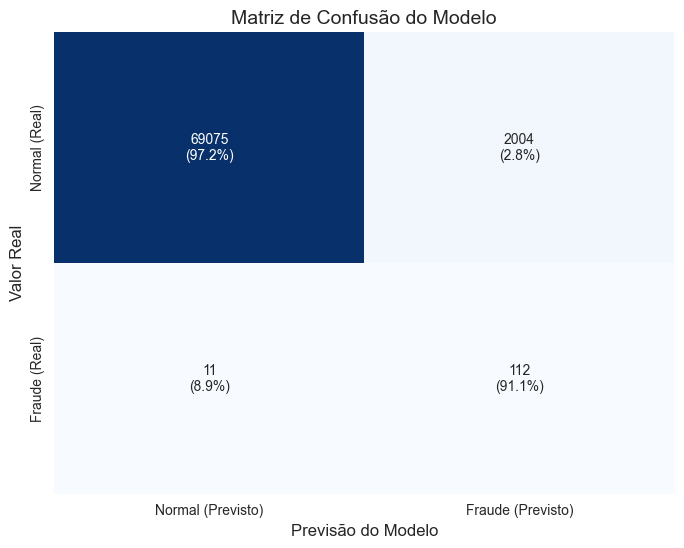

In [34]:
# Gerar e plotar a matriz de confusão melhorada
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Calcular a matriz de confusão normalizada (percentagens)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Criar as anotações combinando contagens e percentagens
labels = [f'{v1}\n({v2:.1%})' for v1, v2 in zip(cm.flatten(), cm_normalized.flatten())]
labels = np.asarray(labels).reshape(cm.shape)

# Plotar a matriz de confusão com anotações combinadas
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Normal (Previsto)', 'Fraude (Previsto)'],
            yticklabels=['Normal (Real)', 'Fraude (Real)'])
plt.title('Matriz de Confusão do Modelo', fontsize=14)
plt.xlabel('Previsão do Modelo', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.show()

### Estrutura da Matriz

* **Eixo Y (Valor Real):** Mostra qual era a classe verdadeira de cada transação (se era "Normal" ou "Fraude").
* **Eixo X (Previsão do Modelo):** Mostra o que o modelo previu para cada transação.

A matriz é dividida em quatro quadrantes, que representam os acertos e erros do modelo.

### Análise dos Quadrantes

#### Verdadeiro Negativo (Superior Esquerdo)
* **Valor:** 69075 (97.2%)
* **Significado:** O modelo previu corretamente 69.075 transações como "Normal" quando elas eram, de fato, normais. Este é um acerto.

#### Falso Positivo (Superior Direito)
* **Valor:** 2004 (2.8%)
* **Significado:** O modelo previu incorretamente 2.004 transações como "Fraude" quando, na verdade, elas eram normais. Este é um erro, também conhecido como **erro do tipo I**. Isso pode gerar inconvenientes para o cliente, como um bloqueio desnecessário do cartão.

#### Falso Negativo (Inferior Esquerdo)
* **Valor:** 11 (8.9%)
* **Significado:** O modelo previu incorretamente 11 transações como "Normal" quando, na verdade, eram fraudes. Este é o erro mais grave em um sistema de detecção de fraudes, pois significa que a fraude não foi detectada, resultando em prejuízo financeiro. É chamado de **erro do tipo II**.

#### Verdadeiro Positivo (Inferior Direito)
* **Valor:** 112 (91.1%)
* **Significado:** O modelo previu corretamente 112 transações como "Fraude" quando elas eram, de fato, fraudes. Este é um acerto crucial para o objetivo do modelo.

### Conclusão do Desempenho do Modelo

* **Detecção de Fraudes:** O modelo conseguiu identificar 91,1% de todas as fraudes reais (112 de 123), o que é um desempenho muito bom.
* **Precisão nas Transações Normais:** O modelo é extremamente preciso ao identificar transações normais, acertando 97,2% das vezes.
* **Pontos de Atenção:** Embora eficiente, o modelo ainda deixou passar 11 fraudes (Falsos Negativos) e classificou indevidamente 2.004 transações normais como fraude (Falsos Positivos).

Em resumo, a imagem mostra um modelo de detecção de fraudes bastante competente, com uma alta taxa de acerto na identificação de fraudes verdadeiras, mas que ainda gera um número considerável de alarmes falsos e perde uma pequena quantidade de fraudes.

In [35]:
# imprimir relatório de classificação
from sklearn.metrics import classification_report
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9718    0.9856     71079
           1     0.0529    0.9106    0.1000       123

    accuracy                         0.9717     71202
   macro avg     0.5264    0.9412    0.5428     71202
weighted avg     0.9982    0.9717    0.9841     71202



In [38]:
# imprimir a acurácia do modelo
from sklearn.metrics import accuracy_score
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

Acurácia: 0.9717



In [37]:
# imprimir a área sob da curva
from sklearn.metrics import roc_auc_score
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

AUC: 0.9412



## Conclusões

Como você pode observar, não se trata de um problema trivial. Apesar dos dados estarem bem tratados e limpos, sem valores ausentes ou variáveis categóricas, o desbalanceamento e a Transformação PCA demandaram um trabalho considerável.

Obviamente, apesar do bom resultado final, há espaço para testar o desempenho com outros algoritmos de classificação, além de otimizar seus parâmetros.

